In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 25th 11:24:03 2018
@author: zyx
這是一個可以計算標準的簡單移動平均法的股票風險值的程式

Updated on Tue Mar 9th 2020
"""
#pip install tejapi
#pip install scipy
#pip install matplotlib

import pandas as pd
import numpy as np
import tejapi
import scipy.stats
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator    
tejapi.ApiConfig.api_key = "yourkey"

In [2]:
##  基礎參數設定，按照要計算的部位
##  波動度計算樣本起迄日
sampledates = ['2020-01-01','2020-12-31']

## 持有的股票淨值
hold_unit = {"2317":[2000.0],"2330":[2000.0]}

## 風險值信賴水準
significant = 0.01
outcome = []

def cal_VaR(hold_unit,significant,sampledates):
    ids =list(hold_unit.keys())
    ##  用來查詢大盤交易日的資料
    data = tejapi.get('TWN/APRCD', coid=['Y9999'],mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','close_d','roib']}, paginate=True)
    
    ##  取得大盤交易日，用來調整共同的交易日用
    alldate_sample = pd.DataFrame({'zdate':data['mdate']})
    
    ##  股價報酬率資料
    data = tejapi.get('TWN/APRCD', coid=ids, mdate={'gte':sampledates[0],'lte':sampledates[1]},opts={"sort":"mdate.desc",'columns':['coid','mdate','close_d','roib']}, paginate=True)    
    cash = {}
    
    for stk_id in ids:
        ##  以淨值初始化現金流物件
        this_prc = data.loc[(data['coid']==stk_id)&(data['mdate']==np.max(data.loc[(data['coid']==stk_id),'mdate'])),'close_d'].values.tolist()
        cash[stk_id]=[hold_unit[stk_id][0]*this_prc[0]]
    cashflow = pd.DataFrame(cash).values
    
    ##  用來設定roi要使用log的
    stockroi =  pd.DataFrame({'stk_id':data['coid'],'zdate':data['mdate'],'roi':data['roib']})
    stockroi['roi'] = stockroi['roi']/100
    
    ##  將本來存在同一個欄位的報酬率拉成分別以該股票為名的欄位
    for i in range(0,len(ids)):
        g = stockroi.loc[stockroi['stk_id']==ids[i],['zdate','roi']].reset_index(drop=True)
        g = g.rename(index=str, columns={"roi": ids[i]})
        alldate_sample =  alldate_sample.merge(g, left_on='zdate', right_on='zdate')
    
    ##  去除不必要的日期欄位
    cov_sample = alldate_sample.drop('zdate', axis=1)
    
    ##  用0補報酬率有效樣本缺失值
    for factor_name in cov_sample:
        rateroi = cov_sample
        rateroi.loc[np.isnan(rateroi[factor_name])==True,factor_name]=0
    
    ##  計算變異數共變異數矩陣
    cov_matrixs = np.cov(cov_sample.T,rowvar='False')
    
    ##  計算信賴區間並計算風險值
    riskvalue = scipy.stats.norm.interval(alpha=(1-2*significant))[0]*np.sqrt(np.matmul(np.matmul(cashflow,cov_matrixs),cashflow.T)[0][0])
    ## print("VaR = "+str(riskvalue))
    return riskvalue  

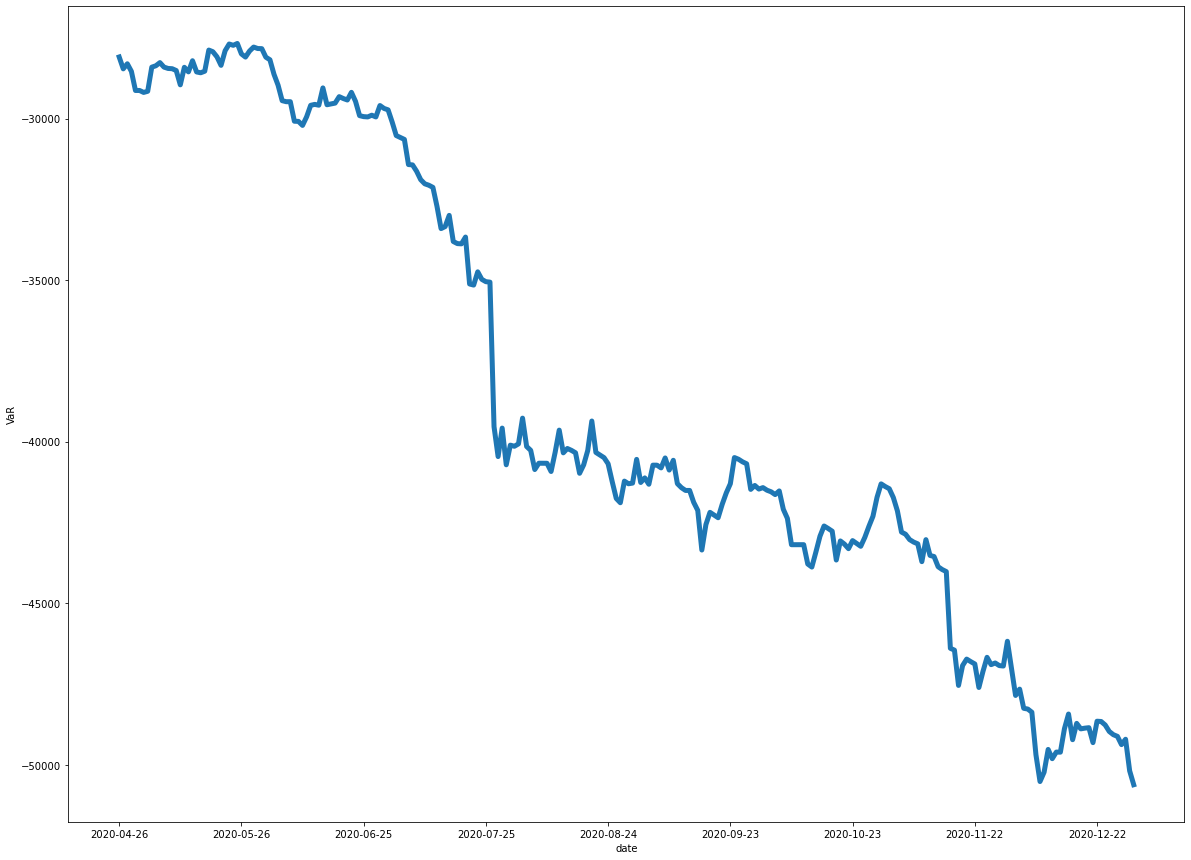

In [3]:
##  執行需要一點時間
for i in range(0,250):  
    riskvalue = cal_VaR(hold_unit,significant,sampledates)
    outcome.append([sampledates[1],riskvalue])
    sampledates_0 = datetime.datetime.strptime(sampledates[0], '%Y-%m-%d') - datetime.timedelta(days = 1)
    sampledates_1 = datetime.datetime.strptime(sampledates[1], '%Y-%m-%d') - datetime.timedelta(days = 1)
    sampledates[0]=sampledates_0.strftime('%Y-%m-%d')
    sampledates[1]=sampledates_1.strftime('%Y-%m-%d')

##  作圖 
final = pd.DataFrame(outcome)    
fig, ax1 = plt.subplots(figsize=(20,15))
xy = final.values
xy = xy[xy[:,0].argsort()]
ax1.plot(xy[:, 0], xy[:, 1], linewidth=5,   markeredgecolor='k', markersize=15)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('date')
plt.ylabel('VaR')
plt.show()  